### Documentación

Problemas interesantes para Aprendizaje por refuerzo
 * Gymnasium: https://gymnasium.farama.org/environments/box2d/

## Instalación

!pip install gymnasium  
!pip install gymnasium[box2d] 

## Acciones adicionales

### En macos

pip uninstall swig  
xcode-select -—install (si no se tienen ya)  
pip install swig  / sudo port install swig-python
pip install 'gymnasium[box2d]' # en zsh hay que poner las comillas  

### en Windows

Si da error, se debe a la falta de la versión correcta de Microsoft Visual C++ Build Tools, que es una dependencia de Box2D. Para solucionar este problema, puede seguir los siguientes pasos:  
 * Descargar Microsoft Visual C++ Build Tools desde https://visualstudio.microsoft.com/visual-cpp-build-tools/.
 * Dentro de la app, seleccione la opción "Herramientas de compilación de C++" para instalar.
 * Reinicie su sesión en Jupyter Notebook.
 * Ejecute nuevamente el comando !pip install gymnasium[box2d] en la línea de comandos de su notebook.

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import gymnasium.utils.play
import pygame
import time
from gymnasium.wrappers import RecordVideo

from MLP import MLP
from AGLunarLander import AG_Lunar_Lander

%matplotlib inline

## **Human play**

In [5]:
# prueba lunar lander por humano
env = gym.make("LunarLander-v3", render_mode="rgb_array")

lunar_lander_keys = {
    (pygame.K_UP,): 2,
    (pygame.K_LEFT,): 1,
    (pygame.K_RIGHT,): 3,
}
gymnasium.utils.play.play(env, zoom=1.5, keys_to_action=lunar_lander_keys, noop=0)

## **Auto-play**

In [ ]:
env = gym.make("LunarLander-v3", render_mode="human")
env_seed = 42
observation, info = env.reset(seed=env_seed)
for _ in range(1000):
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    if terminated or truncated:
        observation, info = env.reset()
env.close()

----

## **Agent training**

In [ ]:
env = gym.make("LunarLander-v3")
architecture = MLP(layers=[8,6,4])
genetic_algorithm = AG_Lunar_Lander(population_size=100, num_ind_exp=3, MLP=architecture, env=env, env_seed=None)

print("model params:", genetic_algorithm.MLP.size)

start = time.time()
GENERATIONS = 1000
genetic_algorithm.evolve(pmut=0.1, pcross=0.7, ngen=GENERATIONS, T=8, trace=50, reverse_sort=True, elitism=False)
minutos, segundos = divmod(time.time()-start, 60)
print(f"*******Tiempo evolución: {int(minutos)} minutos y {segundos:.2f} segundos*******")

best_chromosome = genetic_algorithm.best_global_individual[1]
np.savetxt(f"results_p1/lunar_lander_AG_{GENERATIONS}.txt", best_chromosome)
#save last best individual
np.savetxt(f"results_p1/lunar_lander_AG_{GENERATIONS}_Last.txt", genetic_algorithm.population[0])

model params: 82
Nº gen: 0, Best fitness: -48.2346042601042
Nº gen: 50, Best fitness: 79.03294713450104
Nº gen: 100, Best fitness: 59.481951740069796
Nº gen: 150, Best fitness: 130.03146499202066
Nº gen: 200, Best fitness: 152.51692622990066
Nº gen: 250, Best fitness: 102.16678932207022
Nº gen: 300, Best fitness: 93.06782291327619
Nº gen: 350, Best fitness: 130.23417279483166
Nº gen: 400, Best fitness: 107.65939109370868
Nº gen: 450, Best fitness: 119.67239875323226
Nº gen: 500, Best fitness: 69.74517147460746
Nº gen: 550, Best fitness: 151.85495709635768
Nº gen: 600, Best fitness: 153.5743840516694
Nº gen: 650, Best fitness: 113.46406832244982
Nº gen: 700, Best fitness: 266.39900356653544
Nº gen: 750, Best fitness: 169.69744849820708
Nº gen: 800, Best fitness: 136.87624580506142
Nº gen: 850, Best fitness: 152.24407330888945
Nº gen: 900, Best fitness: 162.43311251164906
Nº gen: 950, Best fitness: 272.08422475070125
Nº gen: 999, Best fitness: 274.11373545151497
*******Tiempo evolución: 

## **Fitnesses evolution**

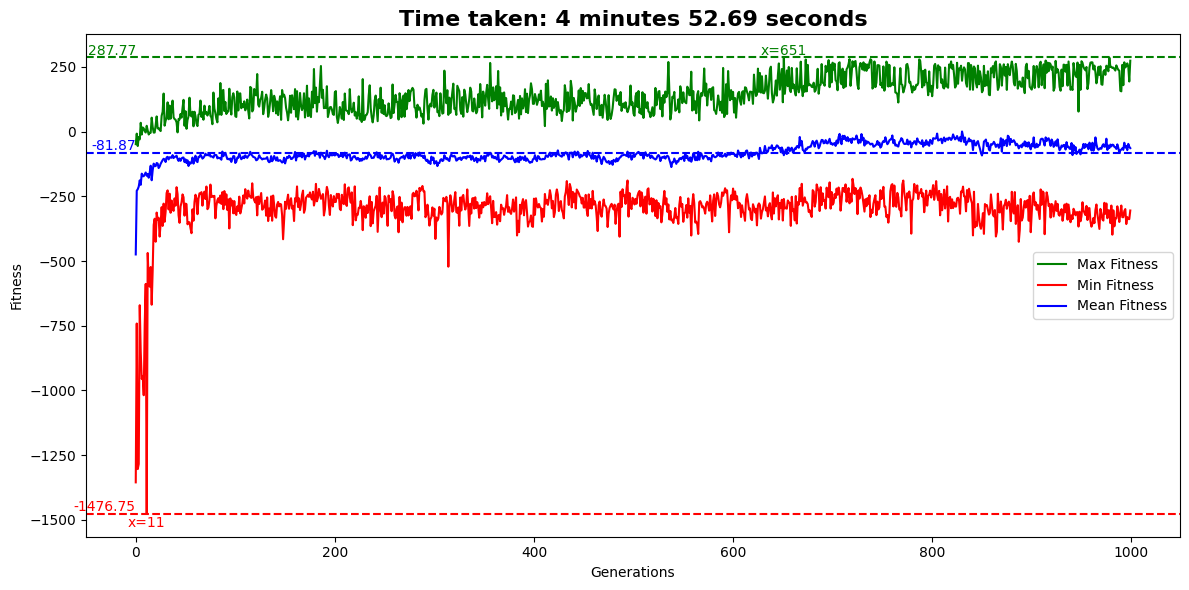

In [ ]:
def plot_fitnesses_evolution():
    plt.figure(figsize=(12, 6))
    
    max_fitness = genetic_algorithm.max_fitnesses
    min_fitness = genetic_algorithm.min_fitnesses
    mean_fitness = genetic_algorithm.mean_fitnesses
    
    max_fitness_gen = np.argmax(max_fitness)
    min_fitness_gen = np.argmin(min_fitness)
    
    plt.plot(max_fitness, label="Max Fitness", color='g')
    plt.axhline(y=max(max_fitness), color='g', linestyle='--')
    plt.text(max_fitness_gen, max(max_fitness)+10, f"x={max_fitness_gen}", color='g', ha="center")
    plt.text(0, max(max_fitness)+10, f'{max(max_fitness):.2f}', color='g', ha='right') # max value
    
    plt.plot(min_fitness, label="Min Fitness", color='r')
    plt.axhline(y=min(min_fitness), color='r', linestyle='--')
    plt.text(min_fitness_gen, min(min_fitness)-50, f"x={min_fitness_gen}", color='r', ha="center")
    plt.text(0, min(min_fitness)+10, f'{min(min_fitness):.2f}', color='r', ha='right') # min value
        
    plt.plot(mean_fitness, label="Mean Fitness", color='b')
    plt.axhline(y=np.mean(mean_fitness), color='b', linestyle='--')
    plt.text(0, np.mean(mean_fitness)+10, f'{np.mean(mean_fitness):.2f}', color='b', ha='right') # mean value
    
    plt.xlabel("Generations")
    plt.ylabel("Fitness")
    plt.title(f"Time taken: {int(minutos)} minutes {segundos:.2f} seconds", fontsize=16, ha='center', fontweight='bold')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"results_p1/lunar_lander_AG_{GENERATIONS}.png")
    plt.show()

plot_fitnesses_evolution()

## **Test best global chromosome**

In [ ]:
test_chromosome = np.loadtxt(f"results_p1/lunar_lander_AG_{GENERATIONS}.txt").tolist()
test_model = architecture # previously defined MLP architecture
test_model.from_chromosome(test_chromosome)

num_episodes_test = 20
destiny_folder = "results_p1/videos"
test_env = gym.make("LunarLander-v3", render_mode="rgb_array")
test_env = RecordVideo(test_env, video_folder=destiny_folder, name_prefix=f"AG-{GENERATIONS}", episode_trigger=lambda x: x < num_episodes_test)  

def policy(observation):
    s = test_model.forward(observation)
    action = np.argmax(s)
    return action

for episode in range(num_episodes_test):
    state, _ = test_env.reset()
    done = False
    total_reward = 0
    
    while not done:
        action = policy(state)  
        next_state, reward, done, _, _ = test_env.step(action) 
        total_reward += reward
        state = next_state

        if done:
            print(f"Episode {episode + 1}: Total Reward = {total_reward}")

test_env.close()

/home/jaime/Escritorio/UPM/rl/RLGAN-project-MAADM-UPM/.venv/lib/python3.10/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /home/jaime/Escritorio/UPM/rl/RLGAN-project-MAADM-UPM/results_p1/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Episode 1: Total Reward = 298.27386567465663
Episode 2: Total Reward = 283.97494569550673
Episode 3: Total Reward = 281.1864341138653
Episode 4: Total Reward = 282.2107558436887
Episode 5: Total Reward = 274.92084117337635
Episode 6: Total Reward = 250.72166896015625
Episode 7: Total Reward = 272.91910875313783
Episode 8: Total Reward = 263.5361195489164
Episode 9: Total Reward = 234.08627545968417
Episode 10: Total Reward = 284.86465678043464
Episode 11: Total Reward = 279.271280981955
Episode 12: Total Reward = 244.61017105959257
Episode 13: Total Reward = 307.5689775578546
Episode 14: Total Reward = 280.5965573971296
Episode 15: Total Reward = 297.8824219392823
Episode 16: Total Reward = 269.05740117161304
Episode 17: Total Reward = 315.2490650735229
Episode 18: Total Reward = 303.51510092175755
Episode 19: Total Reward = 265.5068492841027
Episode 20: Total Reward = 283.74751324190464


## **¿No has tenido bastante?**

Prueba a controlar el flappy bird https://github.com/markub3327/flappy-bird-gymnasium

pip install flappy-bird-gymnasium

import flappy_bird_gymnasium  
env = gym.make("FlappyBird-v0")

Estado (12 variables):
  * the last pipe's horizontal position
  * the last top pipe's vertical position
  * the last bottom pipe's vertical position
  * the next pipe's horizontal position
  * the next top pipe's vertical position
  * he next bottom pipe's vertical position
  * the next next pipe's horizontal position
  * the next next top pipe's vertical position
  * the next next bottom pipe's vertical position
  * player's vertical position
  * player's vertical velocity
  * player's rotation

  Acciones:
  * 0 -> no hacer nada
  * 1 -> volar